In [1]:
using CSV
using DataFramesMeta
using DataFrames
using CategoricalArrays
using Gadfly
using Statistics
using StatsBase
using Distributions
using StatsFuns
using SpecialFunctions
using StatsFuns
using Optim
using ForwardDiff
using Cairo
using Fontconfig
using Distributed
using Loess
using GLM
using Interpolations
using JLD
cd("/Users/evanrussek/foraging/")
include("sim_learn_funcs.jl")
include("/Users/evanrussek/lockin_data/lockin_analysis/forage_data_funs.jl")


get_fix_df (generic function with 1 method)

In [4]:
data = CSV.read("/Users/evanrussek/desktop/analysis/data/run7_data.csv");
travel_keys = unique(data.travel_key)
travel_key_easy = travel_keys[1]
travel_key_hard = travel_keys[2]
travel_keys_he = [travel_key_hard travel_key_easy];
cdata, n_subj = clean_group_data(data,travel_keys_he);
cdata[!,:sub] = cdata[!,:s_num];
pdata = by(cdata, :sub, df -> prep_subj_data(df));
pdata[!,:remove] .= false;


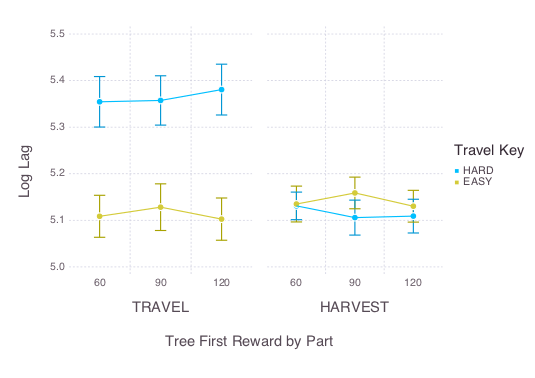

false

In [5]:
pdata_lt = @where(pdata,:lag .< :upper_lag_thresh, :lag .> :lower_lag_thresh)
p = make_group_lag_plot(pdata_lt);
draw(PNG(),p)
### you probably broke the RT effect by timing, etc.

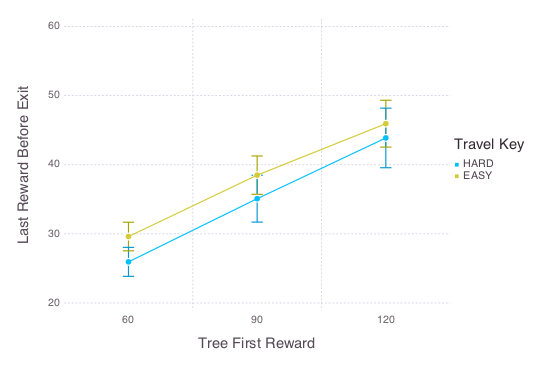

false

In [6]:
p = make_group_exit_plot(pdata, bounds = [20 60]);
draw(PNG(),p)

In [7]:
### plot_group_rr_over_time(pdata)

In [95]:


function make_subj_change_unit_data(data_in)
    s_data = DataFrame(data_in);
    
    subj_change_unit_data = DataFrame();

    # want to group the data into sets of two trials
    # (1,2), (2,3) -- (4,5), (5,6)
    change_unit_trials = [[1,2], [2,3], [4,5], [5,6]]
    for change_unit_idx in 1:length(change_unit_trials)
        this_unit_data = DataFrame();
        this_unit_travel_key_conds = [];
        this_unit_rewards = [];
        for t_idx = 1:2
            this_trial_data = @where(s_data, :trial_num .== change_unit_trials[change_unit_idx][t_idx]);
            this_unit_data = [this_unit_data; this_trial_data];
            push!(this_unit_travel_key_conds, this_trial_data.travel_key_cond[1])
            push!(this_unit_rewards, this_trial_data.start_reward[1])
            # want to write direction of start rewards, travel_key_cond, and time passage...
        end
        # set reward change...
        this_unit_data[!,:reward_change] .= this_unit_rewards[2] - this_unit_rewards[1]

        # set reward direction...
        if this_unit_rewards[1] < this_unit_rewards[2]
            this_unit_data[!,:reward_change_direction] .= "increasing"
        else
            this_unit_data[!,:reward_change_direction] .= "decreasing"
        end;
        # set travel key condition
        this_unit_data[!,:unit_key_cond] .= this_unit_travel_key_conds[1]
        # set unit time elapsed
        this_unit_data[!,:unit_time_elapsed] .= this_unit_data.time_elapsed .- this_unit_data.time_elapsed[1];
        this_unit_data[!,:unit_time_sec] .= this_unit_data[!,:unit_time_elapsed]./1000;
        # label this change number
        this_unit_data[!,:change_unit_number] .= change_unit_idx;
        subj_change_unit_data = [subj_change_unit_data; this_unit_data];
    end
    
    return subj_change_unit_data;
    
end



make_subj_change_unit_data (generic function with 1 method)

In [96]:
##########################
#### change unit data ####
subj_change_unit_data = make_subj_change_unit_data(s_data)
cu_data = by(pdata, :sub, df -> make_subj_change_unit_data(df));
cu_data[!,:remove] .= false;

In [118]:
##########################################################################################
##### now we want to make a plot for increase/decrease x easy/hard change over time ######
##########################################################################################
function make_change_smooth_rr_DF(cu_data)

    cudata_lt = @where(cu_data,:lag .< :upper_lag_thresh2, :lag .> :lower_lag_thresh2);
    cudata_lt.log_lag = log.(cudata_lt.lag);

    ## Initialize DataFrame to store group results
    smooth_rr_DF = DataFrame();

    for s_idx in unique(cudata_lt.sub)
        ## Initialize DataFrame to store subject results
        sub_rr_DF = DataFrame();

        # get subject data
        s_data = @where(cudata_lt, :sub .== s_idx);
        #  zscore it so that different subjects line up...
        s_data.lag_z = zscore(s_data.log_lag);

        # now go through each change_unit
        for cu_idx in 1:4
            # make smoothed model with harvest data...
            s_cu_harvest_data = @where(s_data, :phase .== "HARVEST", :change_unit_number .== cu_idx);
            harvest_DF= try

                harvest_model = loess(s_cu_harvest_data.unit_time_sec, s_cu_harvest_data.lag_z);
                us_harvest = range(extrema(s_cu_harvest_data.unit_time_sec)...; step = 1)
                vs_harvest = Loess.predict(harvest_model, us_harvest);

                DataFrame(trial_time_sec = us_harvest, lag_smooth = vs_harvest, change_unit_num = cu_idx,
                    sub = s_idx, reward_change = s_cu_harvest_data[1,:reward_change], 
                    reward_change_direction =  s_cu_harvest_data[1,:reward_change_direction],
                travel_key_cond = s_cu_harvest_data[1,:travel_key_cond], phase = "HARVEST");
            catch e
                  bt = backtrace()
                  msg = sprint(showerror, e, bt)
                  DataFrame();
            end;

            # make smoothed model with travel data...
            s_cu_travel_data = @where(s_data, :phase .== "TRAVEL", :change_unit_number .== cu_idx);
            travel_DF= try

                travel_model = loess(s_cu_travel_data.unit_time_sec, s_cu_travel_data.lag_z);
                us_travel = range(extrema(s_cu_travel_data.unit_time_sec)...; step = 1)
                vs_travel = Loess.predict(travel_model, us_travel);

                DataFrame(trial_time_sec = us_travel, lag_smooth = vs_travel, change_unit_num = cu_idx,
                    sub = s_idx, reward_change = s_cu_travel_data[1,:reward_change], 
                    reward_change_direction =  s_cu_travel_data[1,:reward_change_direction],
                travel_key_cond = s_cu_travel_data[1,:travel_key_cond], phase = "TRAVEL");
            catch e
                  bt = backtrace()
                  msg = sprint(showerror, e, bt)
                  #println(msg)
                  DataFrame()
            end;
            sub_rr_DF = [sub_rr_DF; harvest_DF; travel_DF];
        end
        if (length(unique(sub_rr_DF.change_unit_num)) == 4)
            smooth_rr_DF = [smooth_rr_DF; sub_rr_DF];
        end
    end
    smooth_rr_DF.trial_time_sec = ceil.(smooth_rr_DF.trial_time_sec);
    return smooth_rr_DF
end


make_change_smooth_rr_DF (generic function with 1 method)

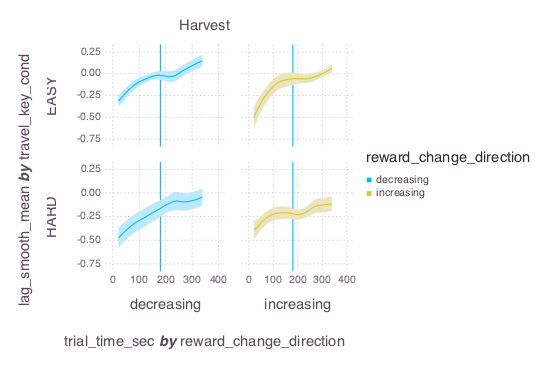

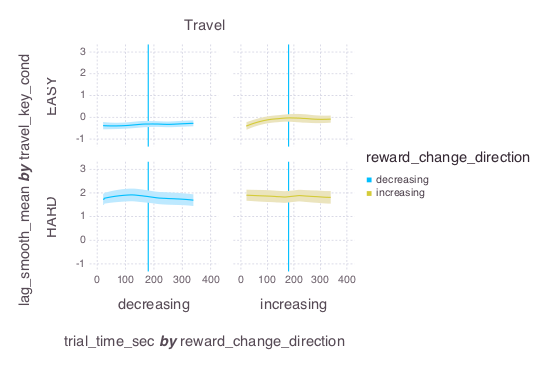

false

In [122]:
### plot group change in lag....
change_smooth_rr_DF = make_change_smooth_rr_DF(cu_data);
smooth_rr_means = by(change_smooth_rr_DF,
    [:trial_time_sec, :reward_change_direction, :travel_key_cond, :phase],
    :lag_smooth => mean,
    :lag_smooth => sem);

smooth_rr_means.upper = smooth_rr_means.lag_smooth_mean + smooth_rr_means.lag_smooth_sem;
smooth_rr_means.lower = smooth_rr_means.lag_smooth_mean - smooth_rr_means.lag_smooth_sem;
#smooth_rr_means.start_reward_cat = CategoricalArray(smooth_rr_means.start_reward);

p1 = plot(@where(smooth_rr_means, :phase .== "HARVEST", 
        :trial_time_sec .> 20, :trial_time_sec .< 340),
    x = :trial_time_sec, y =:lag_smooth_mean, color = :reward_change_direction,
    ymax = :upper, ymin = :lower, ygroup = :travel_key_cond, xgroup = :reward_change_direction,
    xintercept=[180],
    Geom.subplot_grid(Geom.line(), Geom.ribbon(), Geom.vline()), Guide.title("Harvest"));
draw(PNG(), p1)

p2 = plot(@where(smooth_rr_means, :phase .== "TRAVEL", 
        :trial_time_sec .> 20, :trial_time_sec .< 340),
    x = :trial_time_sec, y =:lag_smooth_mean, color = :reward_change_direction,
    xintercept=[180],
    ymax = :upper, ymin = :lower, ygroup = :travel_key_cond,  xgroup = :reward_change_direction,
    Geom.subplot_grid(Geom.line(), Geom.ribbon(), Geom.vline()), Guide.title("Travel"));

draw(PNG(), p2)

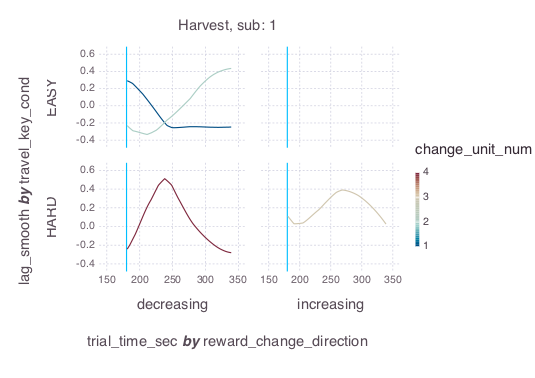

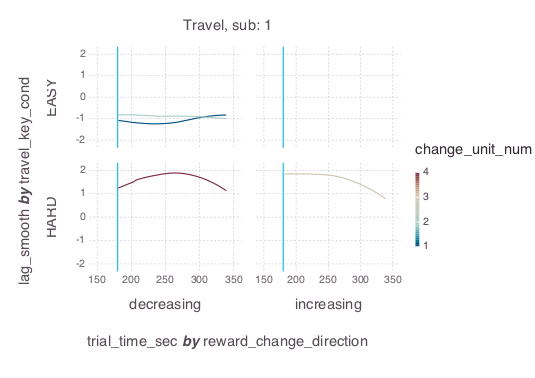

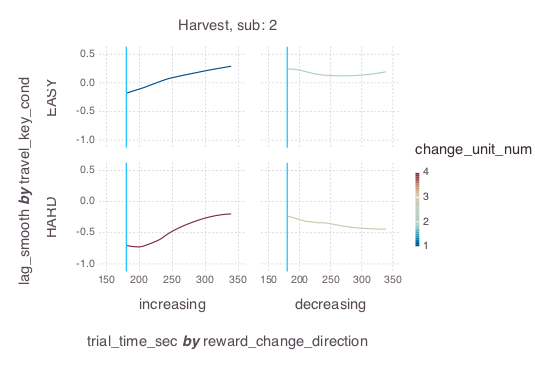

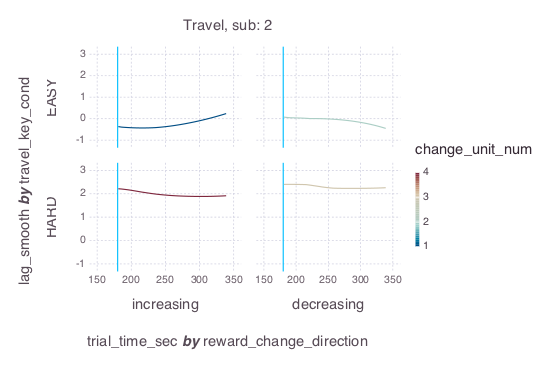

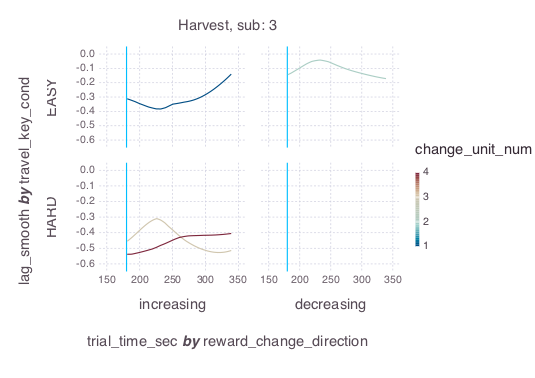

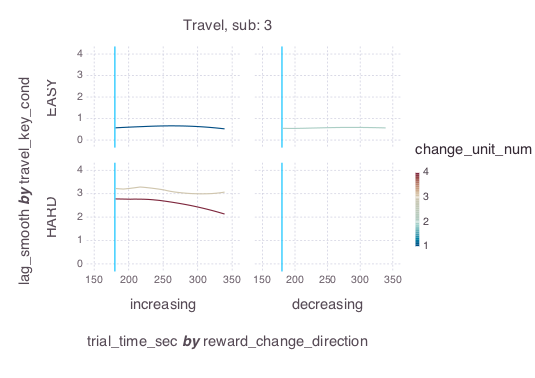

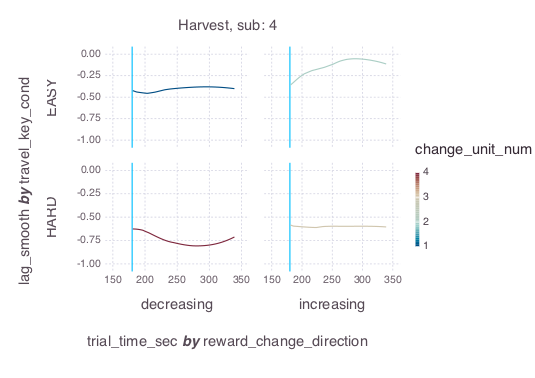

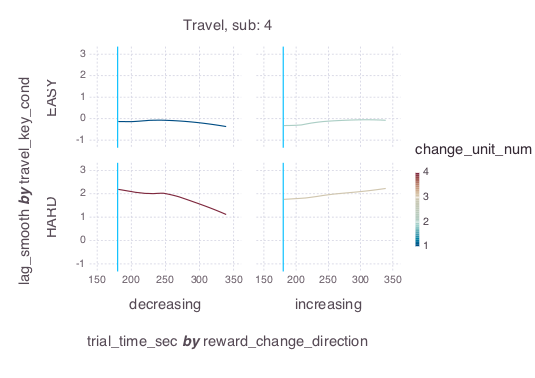

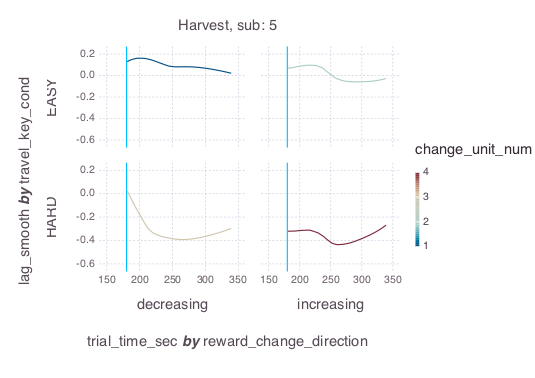

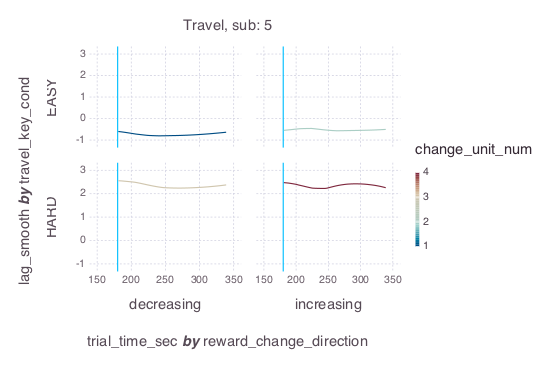

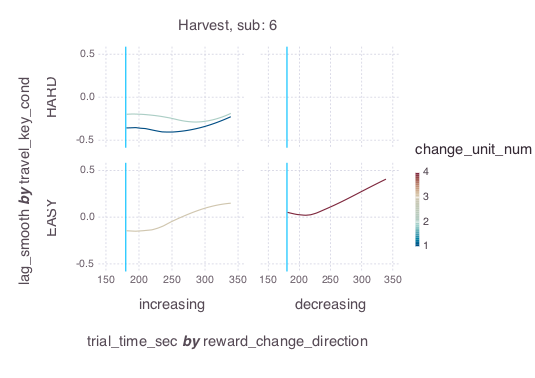

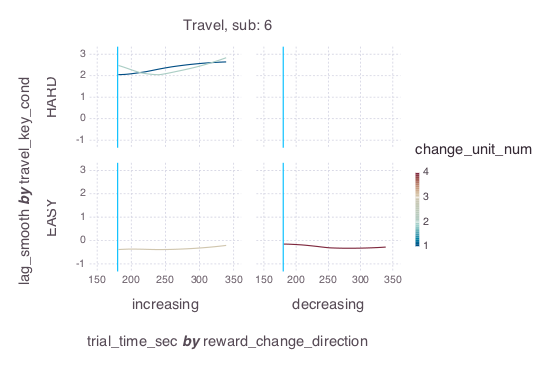

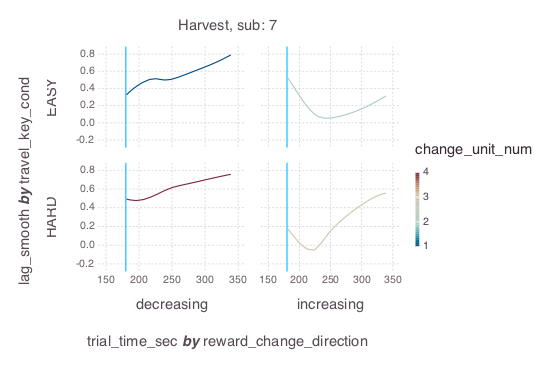

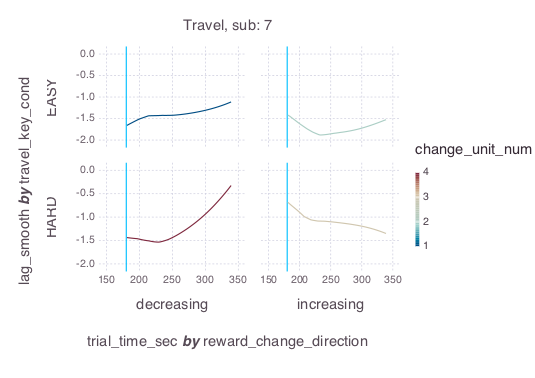

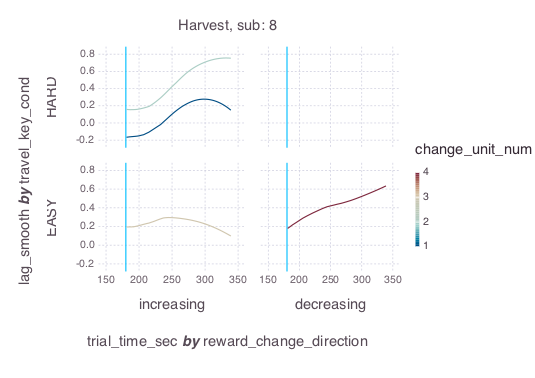

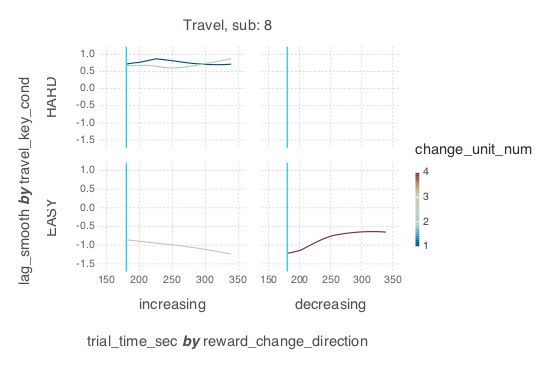

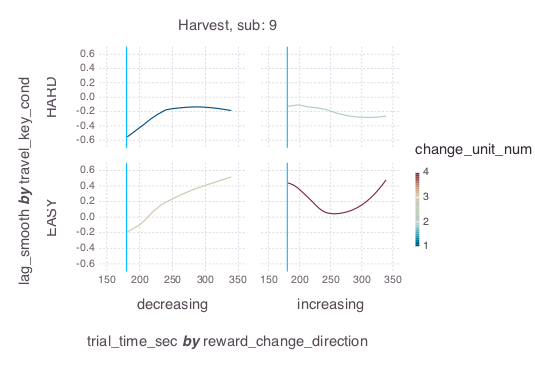

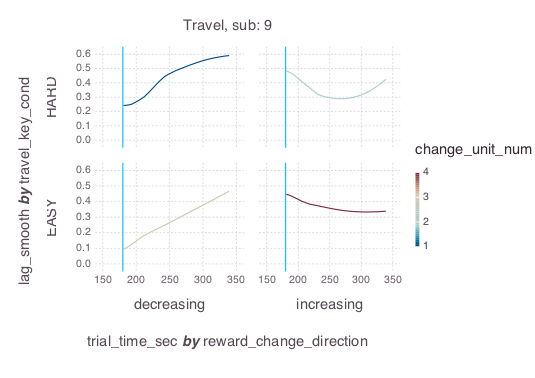

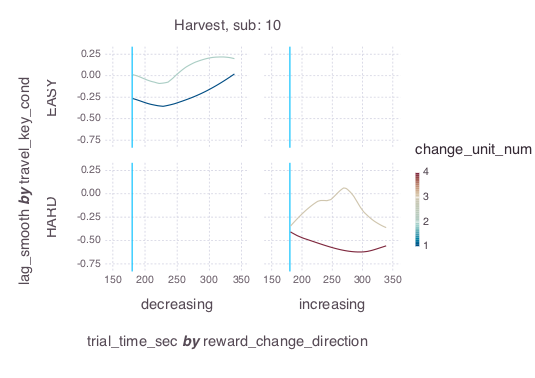

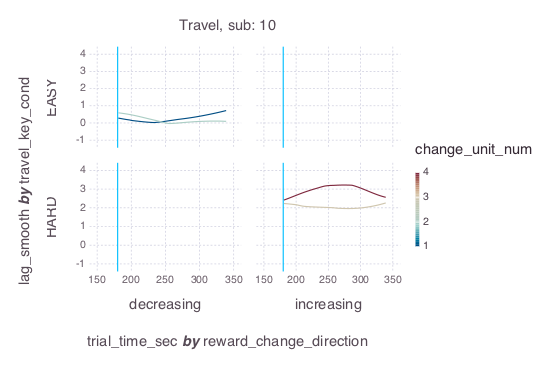

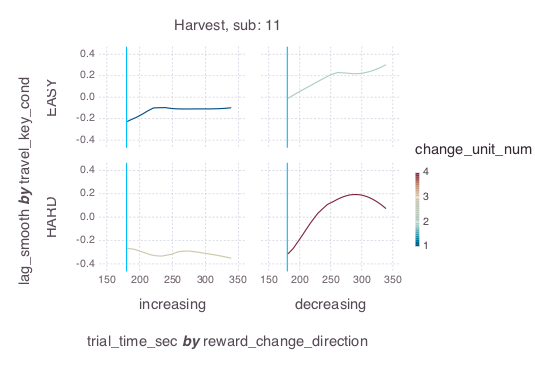

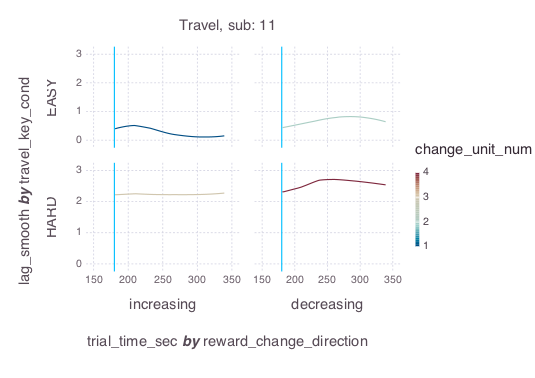

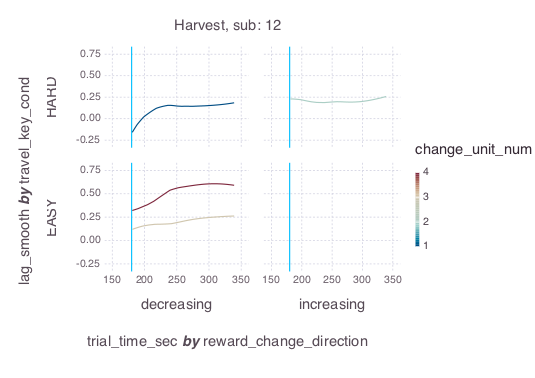

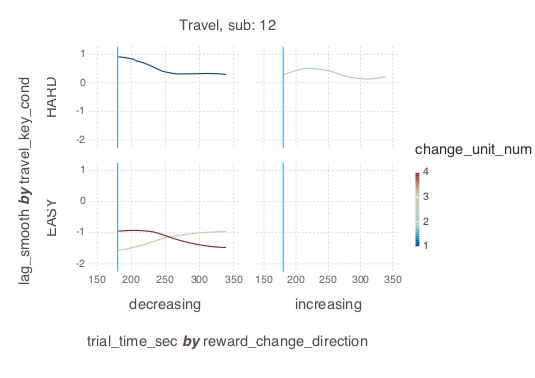

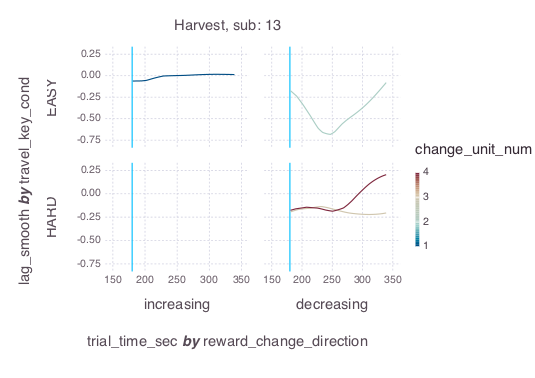

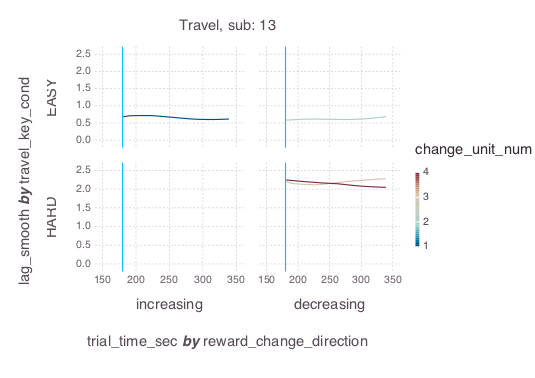

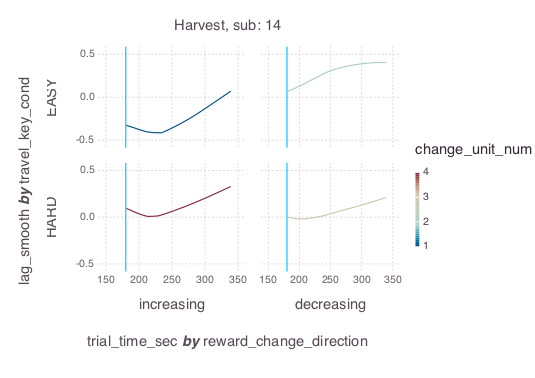

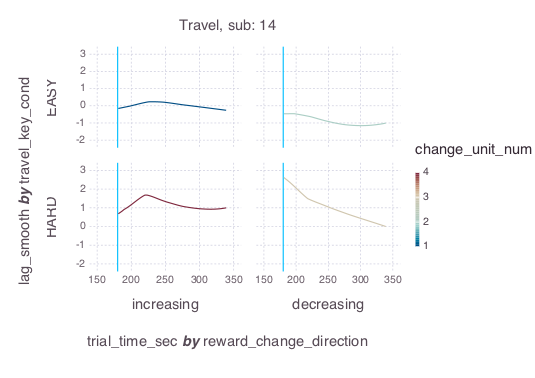

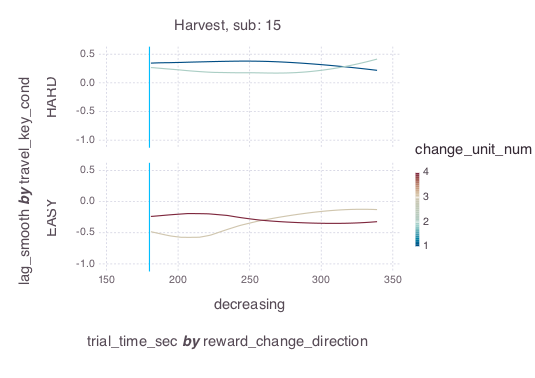

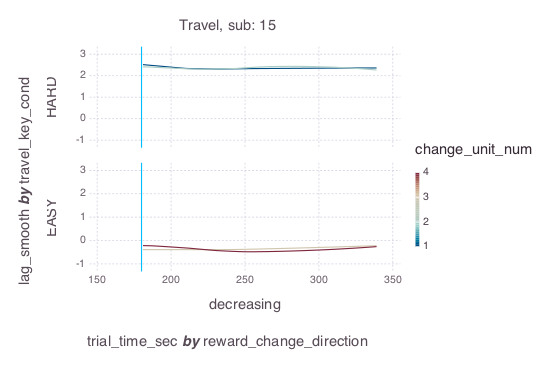

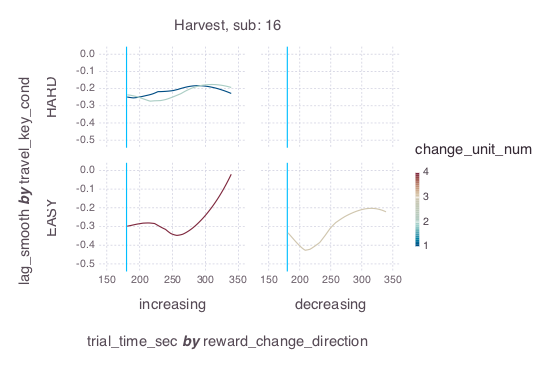

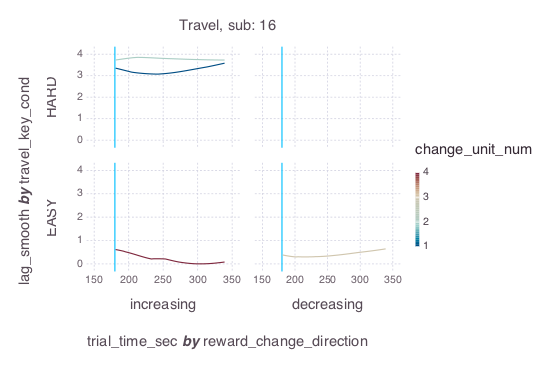

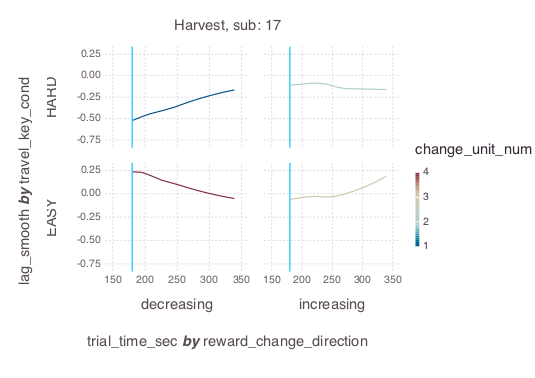

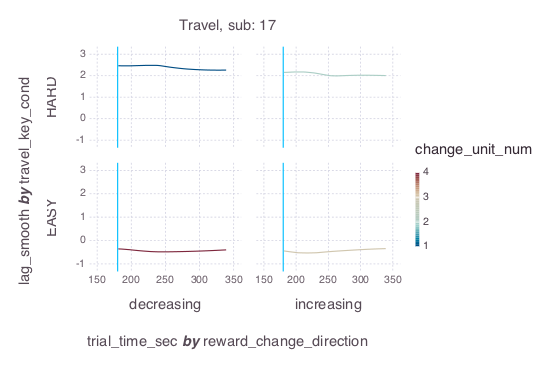

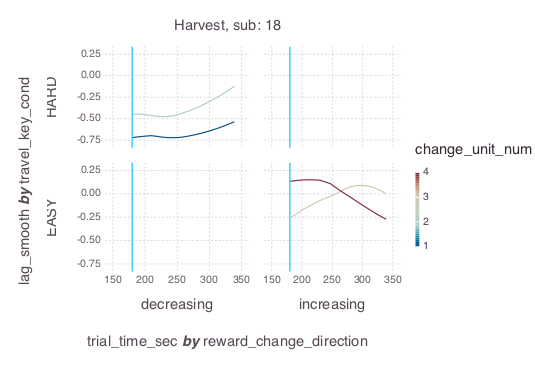

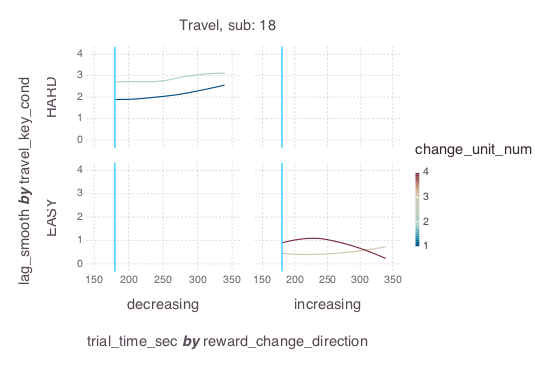

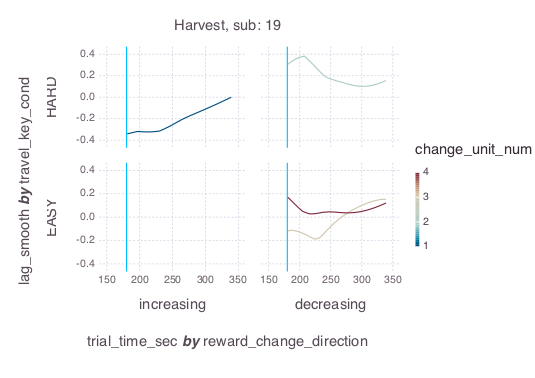

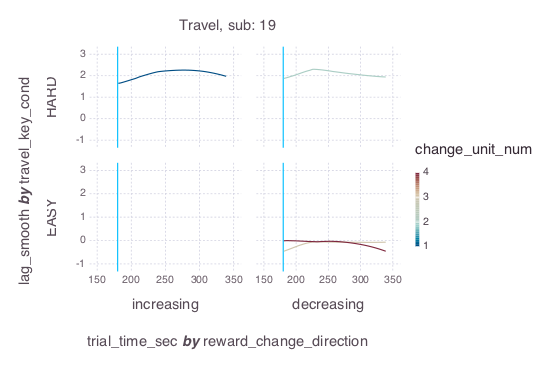

In [143]:
### plot group change in lag....
change_smooth_rr_DF = make_change_smooth_rr_DF(cu_data);
for s_idx = unique(change_smooth_rr_DF.sub);

p1 = plot(@where(change_smooth_rr_DF, :phase .== "HARVEST", :sub .== s_idx,
        :trial_time_sec .> 180, :trial_time_sec .< 340),
    x = :trial_time_sec, y =:lag_smooth, color = :change_unit_num,
    ygroup = :travel_key_cond, xgroup = :reward_change_direction,
    xintercept=[180],
    Geom.subplot_grid(Geom.line(), 
        Geom.vline()), Guide.title(string("Harvest, sub: ", s_idx)));
draw(PNG(), p1)

p2 = plot(@where(change_smooth_rr_DF, :phase .== "TRAVEL", :sub .== s_idx,
        :trial_time_sec .> 180, :trial_time_sec .< 340),
    x = :trial_time_sec, y =:lag_smooth, color = :change_unit_num,
    xintercept=[180], ygroup = :travel_key_cond,  xgroup = :reward_change_direction,
    Geom.subplot_grid(Geom.line(), Geom.vline()), Guide.title(string("Travel, sub: ", s_idx)));

draw(PNG(), p2)
end